In [7]:
import os
import warnings
import math

import pandas as pd
import numpy as np

from tqdm import tqdm

from jre_utils.datapath import (
    DATA_DIRECTORY_PATH,
    get_derived_csv_path,
)
from jre_utils.config import asset_types

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [8]:
def area_to_int(area):
    if area == "2,000 m^2 or greater.":
        return 2000
    elif area == "5000 m^2 or greater.":
        return 5000
    else:
        return int(area)

In [9]:
import json
from pprint import pprint

sub_city_to_city_path = f"{DATA_DIRECTORY_PATH}/core_scraped/sub_city_to_city.json"
with open(sub_city_to_city_path) as fd:
     sub_city_to_city = json.load(fd)
     pprint(f"E.g. Maps 1101 to {sub_city_to_city["1101"]}")

area_code_to_area_path = f"{DATA_DIRECTORY_PATH}/core_scraped/area_code_to_area.json"
with open(area_code_to_area_path) as fd:
     area_code_to_area = json.load(fd)
     pprint(f"E.g. Maps 1100 to {area_code_to_area["1100"]}") 

# In the future, we may want to use the 175 sub cities and just skip this
# Problem currently is that we don't have taxable income for sub cities
def get_city_code(area_code):
     return sub_city_to_city.get(area_code, area_code)

def get_area_from_area_code(area_code):
     return area_code_to_area.get(area_code, "na" )

'E.g. Maps 1101 to 1100'
'E.g. Maps 1100 to Hokkaido Sapporo-shi'


In [10]:
prefecture_code = 26
trade_prices_data_path = f"{DATA_DIRECTORY_PATH}/core"

trade_prices_data_paths = [
    f"{trade_prices_data_path}/{filename}"
    for filename in sorted(os.listdir(trade_prices_data_path))
]
trade_prices_data_paths[prefecture_code - 1]

'../../data/core/26_Kyoto Prefecture_20053_20232.csv'

In [11]:
df = pd.read_csv(trade_prices_data_paths[prefecture_code - 1], encoding="unicode_escape", index_col="No")
df["area_code"] = df["City,Town,Ward,Village code"].astype(str)

# we may want to skip the following step in the future
df["area_code"] = df["area_code"].apply(get_city_code).astype(str)
df["area"] = df["area_code"].apply(get_area_from_area_code)

df["trade_price"] = df["Transaction-price(total)"]
df["trade_area"] = df["Area(m^2)"].apply(area_to_int)
df["unit_price"] = df["Transaction-price(Unit price m^2)"]
df["trade_price_per_area"] = df["trade_price"] / df["trade_area"]

df["quarter"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[0][0]))
df["year"] = df["Transaction period"].apply(lambda x: int(x.split(" ")[2]))

df["unit_price"] = np.where(
    df["unit_price"].isna(),
    df["trade_price_per_area"],
    df["unit_price"],
)

# Only buildings df for now
df = df[df["Type"] == asset_types["building"]["label"]]


In [12]:
area_code = 26209
columns = ["Type", "Region", "Area", "Transaction-price(total)", "Area(m^2)", "Nearest stationFDistance(minute)", "Use", "Purpose of Use", "Frontage roadFClassification", "Transaction period", "year", "unit_price"]
area_df = df[(df["City,Town,Ward,Village code"] == area_code)]
area_df[area_df["year"].isin(list(range(2020, 2022)))].sort_values(by=["year", "quarter"])[columns]


,Type,Region,Area,Transaction-price(total),Area(m^2),Nearest stationFDistance(minute),Use,Purpose of Use,Frontage roadFClassification,Transaction period,year,unit_price
No,,,,,,,,,,,,
26204,Residential Land(Land and Building),Residential Area,Ichimombashi,13000000,100,16,House,NaN,Private Road,1st quarter 2020,2020,130000.000000
26362,Residential Land(Land and Building),Residential Area,Okukaiinji,33000000,90,21,House,House,City Road,1st quarter 2020,2020,366666.666667
26363,Residential Land(Land and Building),Residential Area,Okukaiinji,29000000,85,23,House,House,City Road,1st quarter 2020,2020,341176.470588
26364,Residential Land(Land and Building),Residential Area,Okukaiinji,33000000,90,21,House,House,Private Road,1st quarter 2020,2020,366666.666667
26365,Residential Land(Land and Building),Residential Area,Okukaiinji,30000000,140,16,House,House,Private Road,1st quarter 2020,2020,214285.714286
...,...,...,...,...,...,...,...,...,...,...,...,...
27043,Residential Land(Land and Building),Residential Area,Hanayama,54000000,240,11,House,House,City Road,4th quarter 2021,2021,225000.000000
27044,Residential Land(Land and Building),Residential Area,Hanayama,47000000,250,10,House,House,City Road,4th quarter 2021,2021,188000.000000
27045,Residential Land(Land and Building),Residential Area,Hanayama,76000000,440,10,House,House,City Road,4th quarter 2021,2021,172727.272727


In [13]:
area_df.groupby("year").agg({"unit_price": "median"})

,unit_price
year,
2005,288311.688312
2006,320000.000000
2007,269617.893756
2008,308101.851852
2009,280000.000000
2010,290909.090909
2011,269696.969697
2012,292058.823529
2013,266666.666667


(282, 36)

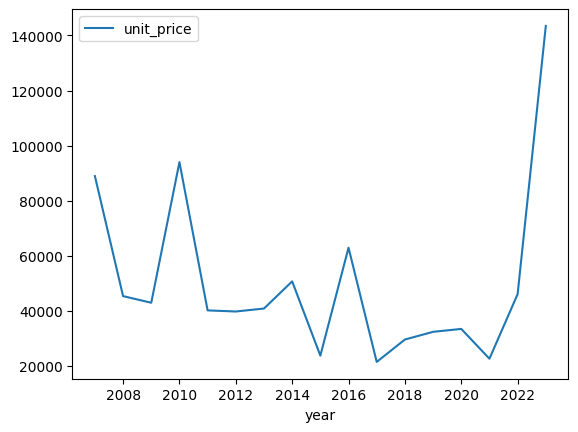

In [197]:
# Pre Heuristic
area_df.groupby("year").agg({"unit_price": "median"}).plot()


(262, 36)

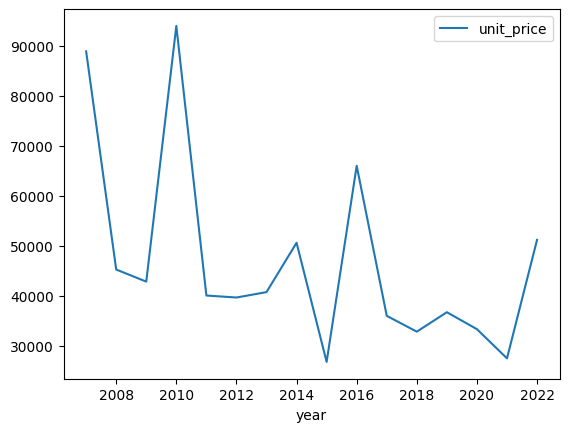

In [196]:
# Post Heuristic
new_area_df = area_df[area_df["year"] <= 2022]
new_area_df = new_area_df[
    (new_area_df["Region"] != "Industrial Area") &
    (~new_area_df["Use"].str.contains("Factory|Warehouse|Parking Lot", na=False, regex=True)) &
    (~new_area_df["Purpose of Use"].str.contains("Factory|Warehouse|Parking Lot", na=False, regex=True))
]

new_area_df.groupby("year").agg({"unit_price": "median"}).plot()


In [ ]:
area_codes_used = [
    "7547", # industrial area issue # Fukushima issue
    "7545", # industrial area issue # Fukushima issue
    "7543", # industrial area issue # Fukushima issue
    "34203" # industrial area issue
    "37322", # weighted median issue
    "1608", # No obvious heuristics. raw data is janky.
    "10429", 
    "10429", # signals in data. Can't really complain
    "10345", # signals in data. Can't really complain
    "16209", # industrial area issue
    "36206"
]
"""
Heurisitics:
(df["Region"] != "Industrial Area") &
(not df["Use"].str.contains( any of ["Factory", "Warehouse", "Parking Lot"])
(not df["Purpose of Use"].str.contains(["Factory", "Warehouse", "Parking Lot"])

Remove edge cases with years with only one count. Edges are harder to smooth.
Remove 2023. Partial data is just noise.
Add count as a smoothing parameter. // Maybe unnecessary
"""




In [93]:
"""
Fixed this bizarre bug with the transaction year code. Lesson, keep dataframe operations simple.
Area Weighted puts too much weight into transactions that have 2000 m^2 or greater. Use median.
"""

''

In [51]:
# df[(df["Region"] == "Residential Area") & (df["Area(m^2)"] == "2,000 m^2 or greater.")]


In [33]:
"""
I may need to define a bit more involved logic and steps to determine when to include a transaction and when to discard it
For example, the industrial area case with the 2000 m^2 or greater area is to be thrown away.
However, this does necessarily not mean I should throw away all transactions with 2000 m^2 or greater area.
Some are for housing complexes and may include valid signals as the prices, while discounted, should be reflective of the market's opinion.
As such, I should dive deep into the intricacies of this dataset and try to understand its nuances
The input dataset is of the utmost importance
"""

"""
Task: Filter out undesirable transactions
Fitering post smoothing is less meaningful. The undesirable transactions impact the nearby ones.
Filtering out years after aggregation is wasteful.
Figure out heuristics to filter out anomalies. This is a form of smoothing.
The only filtering we do should be done with transactions. We don't filter our years.
Years will be frontfilled and smoothed.
Set count = 0 for all frontfilled values.
"""

"""
Task: Filter out undesirable transactions

1. Identify the municipalities and years that we filtered out in the dataset building notebook.
2. Go into the transactions to figure out what caused them to be anomalies. Then, figure out patterns in those anomalies.
3. Use those patterns to generate a heuristic.

Repeat steps 1, 2 and 3 until we no longer feel the need to filter out transactions.
This could be a multi-day process.
"""

''

In [18]:
# Oh shit, we are leaving behind a lot of data in pre-owned condominiums
df["Type"].value_counts()

Type
Pre-owned Condominiums, etc.           250051
Residential Land(Land and Building)    184604
Residential Land(Land Only)             98244
Forest Land                               608
Agricultural Land                         137
Name: count, dtype: int64

In [21]:
# correlation between returns of each segment
# remove because some years might have only warehouses whereas others have only houses for low count areas

df["Purpose of Use"].value_counts()

#

Purpose of Use
House        242985
Other         24474
Office         5276
Shop           3175
Warehouse       862
Factory         467
Name: count, dtype: int64

In [17]:
df["Use"].value_counts()

Use
House                                                356759
Housing Complex                                       16374
House, Shop                                            3406
Office                                                 3194
Shop                                                   2248
                                                      ...  
Factory, Parking Lot, Shop                                1
Housing Complex, Factory, Office, Workshop                1
Factory, Workshop, Other                                  1
Housing Complex, Workshop, Warehouse, Parking Lot         1
Warehouse, Shop, Other                                    1
Name: count, Length: 216, dtype: int64

In [19]:
# Once we've decided on a Area Code, we can drill down to City Planning to identify the type of zone we want to invest in
# Same for Use
df["City Planning"].value_counts()

City Planning
Category I Exclusively Low-story Residential Zone       129904
Commercial Zone                                          95719
Quasi-industrial Zone                                    74733
Category I Exclusively Medium-high Residential Zone      74185
Category I Residential Zone                              58270
Neighborhood Commercial Zone                             51686
Category II Exclusively Medium-high Residential Zone     12743
Category II Residential Zone                             10857
Industrial Zone                                           7411
Quasi-residential Zone                                    7112
Category II Exclusively Low-story Residential Zone        3768
Non-divided City Planning Area                             830
Urbanization Control Area                                  820
Exclusively Industrial Zone                                346
Outside City Planning Area                                 209
Quasi-city Planning Area                 

In [152]:
df["Frontage roadFClassification"].value_counts()

Frontage roadFClassification
City Road                        9131
Prefectural Road                 1451
Road                              789
Town Road                         420
National Road                     354
Private Road                      353
Agricultural Road                  57
Access Road                        32
Village Road                       26
Kyoto/ Osaka Prefectural Road       4
Ward Road                           2
Forest Road                         2
Hokkaido Prefectural Road           1
Name: count, dtype: int64

In [162]:
# Price by class 
# classification = "Frontage roadFClassification"
classification = "Use"
pd.DataFrame(df.groupby(classification)["unit_price"].mean().sort_values(ascending=False))

,unit_price
Use,
"Housing Complex, Shop, Other",3.333333e+06
"House, Housing Complex, Other",3.363636e+05
"Housing Complex, Parking Lot, Other",2.417647e+05
"Office, Parking Lot, Other",2.300000e+05
"Factory, Office, Warehouse, Shop",2.100000e+05
...,...
"Factory, Warehouse, Parking Lot",3.636364e+03
"House, Workshop, Parking Lot",3.500000e+03
"Office, Workshop, Warehouse, Other",2.798529e+03


In [23]:
# split into Purpose of Use
# Frontfill each and smooth to get a consistent chart
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 533644 entries, 1 to 533644
Data columns (total 28 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Type                                533644 non-null  object 
 1   Region                              282848 non-null  object 
 2   City,Town,Ward,Village code         533644 non-null  int64  
 3   Prefecture                          533644 non-null  object 
 4   City,Town,Ward,Village              533644 non-null  object 
 5   Area                                533398 non-null  object 
 6   Nearest stationFName               531523 non-null  object 
 7   Nearest stationFDistance(minute)   522855 non-null  object 
 8   Transaction-price(total)            533644 non-null  int64  
 9   Layout                              240590 non-null  object 
 10  Area(m^2)                           533644 non-null  object 
 11  Transaction-price(Unit price m^

In [ ]:
# We can use transac